In [1]:
import os
import csv
import math
import re

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

In [2]:
fontsize=14
outfolder="plots"

datasets = [
    "books_200M_uint64",
    "fb_200M_uint64",
]
variants = range(10)

def get_ds_name(ds):
    short_name = ds[:ds.find("_", 0, -1)]
    byte_size = re.search(r'[0-9]+$', ds, re.IGNORECASE).group()
    if short_name == "fb":
        return f"face{byte_size}"
    elif short_name == "books":
        return f"amzn{byte_size}"
    return f"{short_name}{byte_size}"

def get_ds_size(ds):
    return re.search(r'_([0-9]+M)_', ds, re.IGNORECASE).group(1)

def aggregate(data, num_bins=10, normalize=False, cumulative=False):
    data = np.pad(data, (0, max(0, num_bins - len(data))), 'constant')
    bin_width = int(len(data) / num_bins)
    
    res = []
    total = 0
    for b in range(num_bins):
        bin_cnt = 0
        for i in range(b * bin_width, (b+1) * bin_width):
            bin_cnt += data[i]
            total += data[i]
        res.append(bin_cnt)
        
    if normalize:
        res = [float(b) / float(total) for b in res]
    
    if cumulative:
        c = 0.0
        for i, b in enumerate(res):
            c += b
            res[i] = c
        
    return res

plotting books_200M_uint64, variant 0
plotting books_200M_uint64, variant 1
plotting books_200M_uint64, variant 2
plotting books_200M_uint64, variant 3
plotting books_200M_uint64, variant 4
plotting books_200M_uint64, variant 5
plotting books_200M_uint64, variant 6
plotting books_200M_uint64, variant 7
plotting books_200M_uint64, variant 8
plotting books_200M_uint64, variant 9
plotting fb_200M_uint64, variant 0
plotting fb_200M_uint64, variant 1
plotting fb_200M_uint64, variant 2
plotting fb_200M_uint64, variant 3
plotting fb_200M_uint64, variant 4
plotting fb_200M_uint64, variant 5
plotting fb_200M_uint64, variant 6
plotting fb_200M_uint64, variant 7
plotting fb_200M_uint64, variant 8
plotting fb_200M_uint64, variant 9


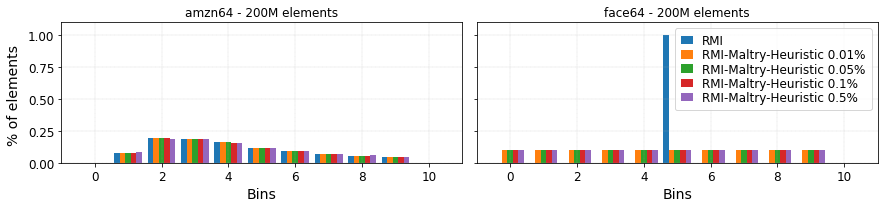

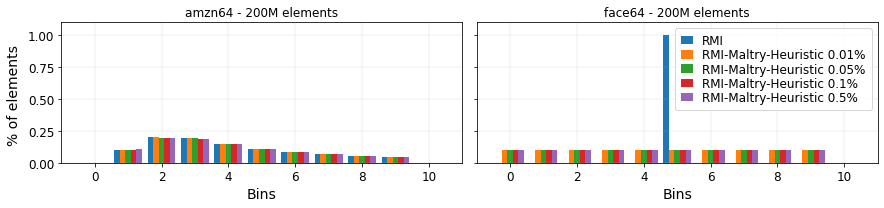

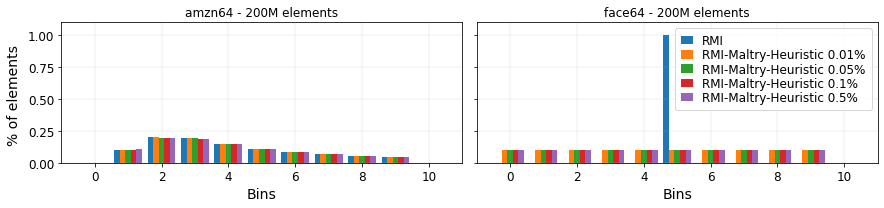

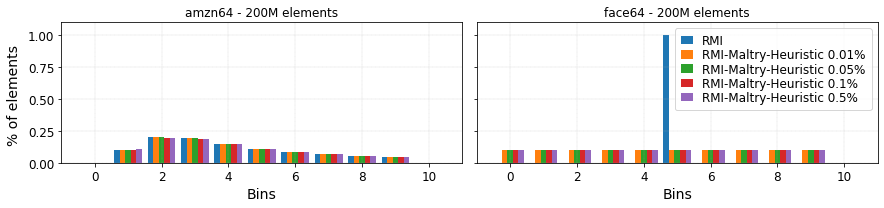

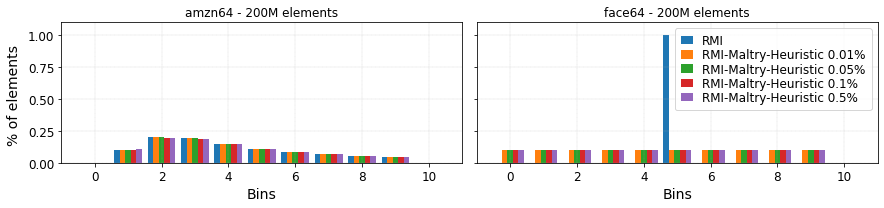

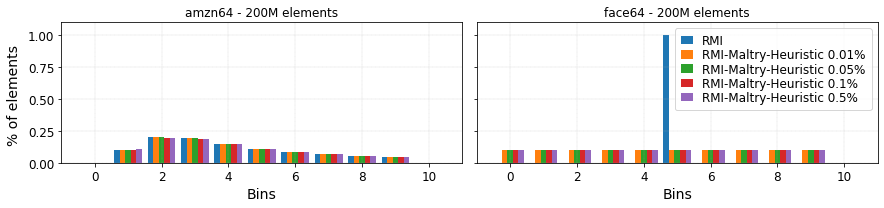

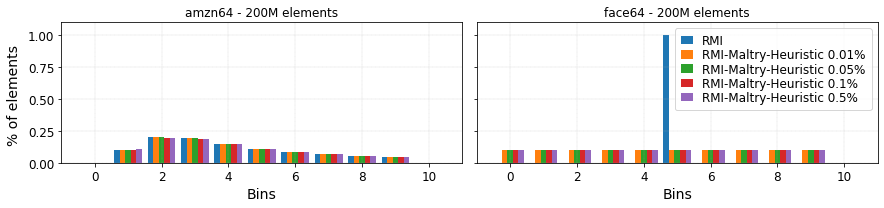

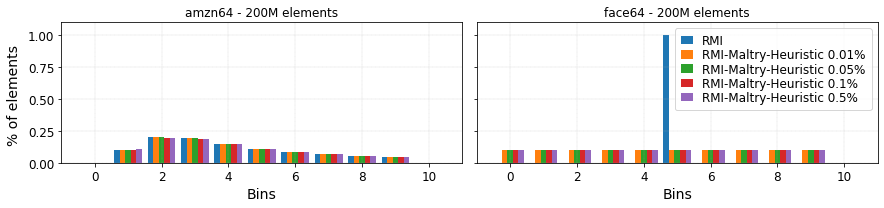

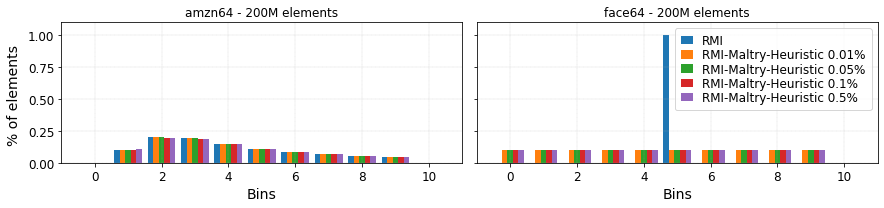

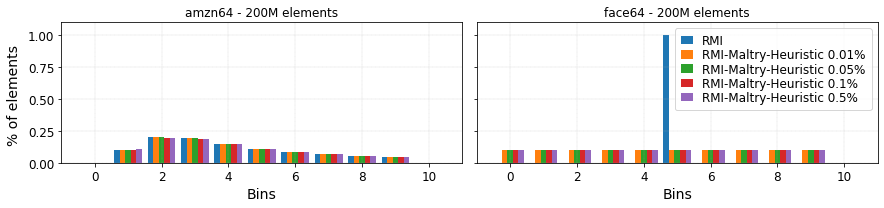

In [14]:
fig_height = 1
fig_width = int(math.ceil(len(datasets) / fig_height))
figs = [plt.subplots(fig_height, fig_width, figsize=(6 * fig_width, 3 * fig_height), sharex=True, sharey=True) for _ in variants]

for i, ds in enumerate(datasets):
    for v in variants:
        print(f"plotting {ds}, variant {v}")
        
        with open(f"../SOSD/results/rmi_segs_{ds}_{v}.csv", newline="") as segs:
            fig, axs = figs[v]
            
            rmi = [int(num) for num in segs.readline().split(",")]
            rmi_rob_1permyriad = [int(num) for num in segs.readline().split(",")]
            rmi_rob_5permyriad = [int(num) for num in segs.readline().split(",")]
            rmi_rob_1permille = [int(num) for num in segs.readline().split(",")]
            rmi_rob_5permille = [int(num) for num in segs.readline().split(",")]
            rmi_rob_0 = [int(num) for num in segs.readline().split(",")]

            x = i % fig_width
            y = int(i / fig_width)
            ax = axs[y][x] if fig_height > 1 else axs[x]
            # ax.set_yscale("log")
            ax.set_title(f"{get_ds_name(ds)} - {get_ds_size(ds)} elements")
            # ax.tick_params(
            #     axis='x',          # changes apply to the x-axis
            #     which='both',      # both major and minor ticks are affected
            #     bottom=False,      # ticks along the bottom edge are off
            #     top=False,         # ticks along the top edge are off
            #     labelbottom=False
            # )
            ax.grid(linestyle='--', linewidth=0.25)
            ax.set_ylim([0, 1.1])
            ax.set_xlim([-1, 11])
            ax.set_xlabel("Bins", fontsize=fontsize)
            ax.tick_params(labelsize=fontsize-2)
            
            # build histogram with fixed bin size
            rmi = aggregate(rmi, normalize=True, cumulative=False)
            rmi_rob_1permyriad = aggregate(rmi_rob_1permyriad, normalize=True, cumulative=False)
            rmi_rob_5permyriad = aggregate(rmi_rob_5permyriad, normalize=True, cumulative=False)
            rmi_rob_1permille = aggregate(rmi_rob_1permille, normalize=True, cumulative=False)
            rmi_rob_5permille = aggregate(rmi_rob_5permille, normalize=True, cumulative=False)
            
            # ax.plot(rmi, label="rmi", linewidth=2.5)
            # ax.plot(rmi_rob_1permyriad, label="robust rmi 0.01%", linewidth=2.0)
            # ax.plot(rmi_rob_5permyriad, label="robust rmi 0.05%", linewidth=1.5)
            # ax.plot(rmi_rob_1permille, label="robust rmi 0.1%", linewidth=1.0)
            # ax.plot(rmi_rob_5permille, label="robust rmi 0.5%", linewidth=0.5)

            label_pos = np.arange(len(rmi))
            bar_width = 1.0 / 6
            ax.bar(label_pos - 2.0 * bar_width, rmi, bar_width, label="RMI")
            ax.bar(label_pos - 1.0 * bar_width, rmi_rob_1permyriad, bar_width, label="RMI-Maltry-Heuristic 0.01%")
            ax.bar(label_pos - 0.0 * bar_width, rmi_rob_5permyriad, bar_width, label="RMI-Maltry-Heuristic 0.05%")
            ax.bar(label_pos + 1.0 * bar_width, rmi_rob_1permille, bar_width, label="RMI-Maltry-Heuristic 0.1%")
            ax.bar(label_pos + 2.0 * bar_width, rmi_rob_5permille, bar_width, label="RMI-Maltry-Heuristic 0.5%")
            # ax.bar(label_pos + 2.5 * bar_width, rmi_rob_0, bar_width, label="rmi robust 0%")
    
for v, (fig, axs) in enumerate(figs):
    ax = axs[0][0] if fig_height > 1 else axs[-1]
    handles, labels = ax.get_legend_handles_labels()

    fig.tight_layout()
    fig.supylabel("% of elements", fontsize=fontsize, x=-.02, y=0.54)
    ax.legend(handles, labels, ncol=1, loc="best", fontsize=fontsize-2, labelspacing=0.1, borderpad=0.5, handlelength=1)
    fig.savefig(f"./plots/rmi_segments_{v}.pdf", bbox_inches="tight", dpi=300)